In [49]:
import math
import pickle
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from UDFManager import *
from pyudf.rotation import Quaternion

plt.style.use('presentation')

In [50]:
def quaternionToRotationArray(q):
    return [
        [1 - 2 * (q.q2 * q.q2 + q.q3 * q.q3), 2 * (q.q1 * q.q2 + q.q0 * q.q3), 2 * (q.q3 * q.q1 - q.q0 * q.q2)],
        [2 * (q.q1 * q.q2 - q.q0 * q.q3), 1 - 2 * (q.q1 * q.q1 + q.q3 * q.q3), 2 * (q.q2 * q.q3 + q.q0 * q.q1)],
        [2 * (q.q3 * q.q1 + q.q0 * q.q2), 2 * (q.q2 * q.q3 - q.q0 * q.q1), 1 - 2 * (q.q1 * q.q1 - q.q2 * q.q2)]
    ]

In [51]:
RHO = 1.0
MU  = 1.0
a   = 5.0
h   = a / 2.0
gra = 0.06

gravity = np.array([0.0, 1.0, 0.0]) * (gra * RHO * 4 / 3 * np.pi * (a**3))

In [66]:
gammadot_map = {}
radian_map   = {}
tr_hy_map    = {}
tr_s_map     = {}
tr_bh_map    = {}
tr_cs_map    = {}
tr_cbh_mao   = {}

In [93]:
gammadots = []
radians   = []
tr_hys    = []
tr_ss     = []
tr_bhs    = []
tr_css    = []
tr_cbhs   = []

for i in tqdm(range(0, 105, 5)):
    uobj = UDFManager(f'00/udf/{i:0=3}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf
    radian = np.zeros(nt)
    
    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        rotation_matrix = quaternionToRotationArray(q)[1]
        radian[n] = np.arccos(rotation_matrix[1])
        tr_cbh[n] = (np.cross(rotation_matrix, gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)
    
    radians.append(radian)
    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
#     print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

gammadot_map['00'] = gammadots
radian_map['00']   = radians
tr_hy_map['00']    = tr_hys
tr_s_map['00']     = tr_ss
tr_bh_map['00']    = tr_bhs
tr_cs_map['00']    = tr_css
tr_cbh_mao['00']   = tr_cbhs

In [94]:
gammadots = []
radians   = []
tr_hys    = []
tr_ss     = []
tr_bhs    = []
tr_css    = []
tr_cbhs   = []

for i in tqdm(range(0, 105, 5)):
    uobj = UDFManager(f'01/udf/{i:0=3}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf
    radian = np.zeros(nt)
    
    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        rotation_matrix = quaternionToRotationArray(q)[1]
        radian[n] = np.arccos(rotation_matrix[1])
        tr_cbh[n] = (np.cross(rotation_matrix, gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)
    
    radians.append(radian)
    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
#     print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

gammadot_map['01'] = gammadots
radian_map['01']   = radians
tr_hy_map['01']    = tr_hys
tr_s_map['01']     = tr_ss
tr_bh_map['01']    = tr_bhs
tr_cs_map['01']    = tr_css
tr_cbh_mao['01']   = tr_cbhs

In [95]:
gammadots = []
radians   = []
tr_hys    = []
tr_ss     = []
tr_bhs    = []
tr_css    = []
tr_cbhs   = []

for i in tqdm(range(0, 105, 5)):
    uobj = UDFManager(f'02/udf/{i:0=3}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf
    radian = np.zeros(nt)
    
    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        rotation_matrix = quaternionToRotationArray(q)[1]
        radian[n] = np.arccos(rotation_matrix[1])
        tr_cbh[n] = (np.cross(rotation_matrix, gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)
    
    radians.append(radian)
    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
#     print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

gammadot_map['02'] = gammadots
radian_map['02']   = radians
tr_hy_map['02']    = tr_hys
tr_s_map['02']     = tr_ss
tr_bh_map['02']    = tr_bhs
tr_cs_map['02']    = tr_css
tr_cbh_mao['02']   = tr_cbhs

In [118]:
gammadots = []
radians   = []
tr_hys    = []
tr_ss     = []
tr_bhs    = []
tr_css    = []
tr_cbhs   = []

for i in tqdm(range(0, 105, 5)):
    uobj = UDFManager(f'03/udf/{i:0=3}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf
    radian = np.zeros(nt)
    
    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        rotation_matrix = quaternionToRotationArray(q)[1]
        radian[n] = np.arccos(rotation_matrix[1])
        tr_cbh[n] = (np.cross(rotation_matrix, gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)
    
    radians.append(radian)
    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
#     print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

gammadot_map['03'] = gammadots
radian_map['03']   = radians
tr_hy_map['03']    = tr_hys
tr_s_map['03']     = tr_ss
tr_bh_map['03']    = tr_bhs
tr_cs_map['03']    = tr_css
tr_cbh_mao['03']   = tr_cbhs

In [119]:
gammadots = []
radians   = []
tr_hys    = []
tr_ss     = []
tr_bhs    = []
tr_css    = []
tr_cbhs   = []

for i in tqdm(range(0, 105, 5)):
    uobj = UDFManager(f'04/udf/{i:0=3}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf
    radian = np.zeros(nt)
    
    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        rotation_matrix = quaternionToRotationArray(q)[1]
        radian[n] = np.arccos(rotation_matrix[1])
        tr_cbh[n] = (np.cross(rotation_matrix, gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)
    
    radians.append(radian)
    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
#     print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

gammadot_map['04'] = gammadots
radian_map['04']   = radians
tr_hy_map['04']    = tr_hys
tr_s_map['04']     = tr_ss
tr_bh_map['04']    = tr_bhs
tr_cs_map['04']    = tr_css
tr_cbh_mao['04']   = tr_cbhs

In [76]:
l = 0
k = 12

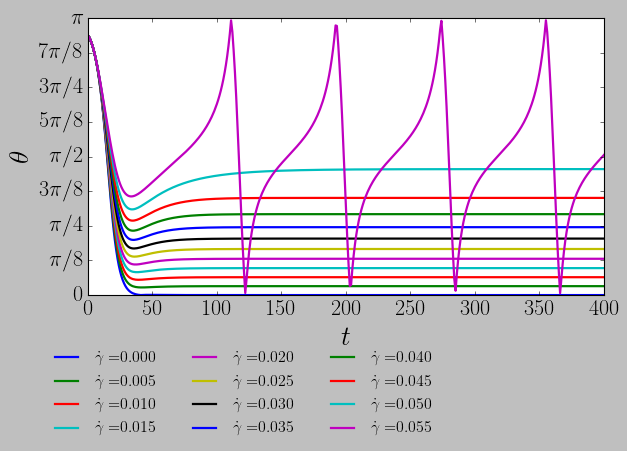

In [77]:
yticks = np.linspace(0, np.pi, 9)
yticks_str = ['$0$', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$', '$5\pi/8$','$3\pi/4$', '$7\pi/8$','$\pi$']
plt.xticks(fontsize=20)
plt.yticks(yticks, yticks_str, fontsize=20)
plt.ylim(0, np.pi)
for d, g in zip(radian_map['00'][l:k], gammadot_map['00'][l:k]):
    plt.plot(d, label='$\dot{\gamma}=$' + f'${g:0=0.3f}$')
plt.xlabel("$t$", fontsize=25)
plt.ylabel(r"$\theta$", fontsize=25)
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.15), loc='upper left')
plt.tight_layout()
plt.savefig('figs/degrees_00.png')

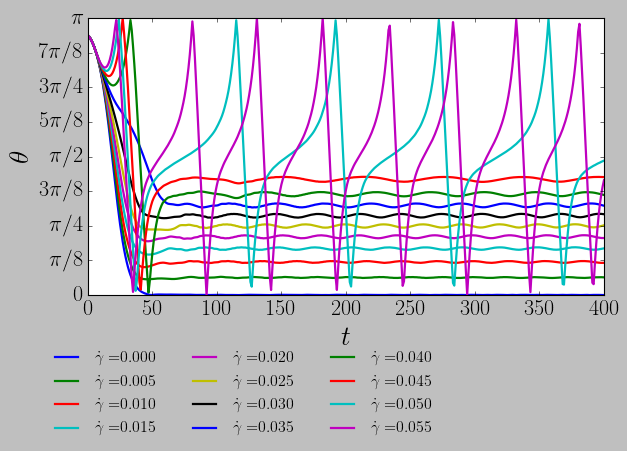

In [78]:
yticks = np.linspace(0, np.pi, 9)
yticks_str = ['$0$', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$', '$5\pi/8$','$3\pi/4$', '$7\pi/8$','$\pi$']
plt.xticks(fontsize=20)
plt.yticks(yticks, yticks_str, fontsize=20)
plt.ylim(0, np.pi)
for d, g in zip(radian_map['01'][l:k], gammadot_map['01'][l:k]):
    plt.plot(d, label='$\dot{\gamma}=$' + f'${g:0=0.3f}$')
plt.xlabel("$t$", fontsize=25)
plt.ylabel(r"$\theta$", fontsize=25)
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.15), loc='upper left')
plt.tight_layout()
plt.savefig('figs/degrees_01.png')

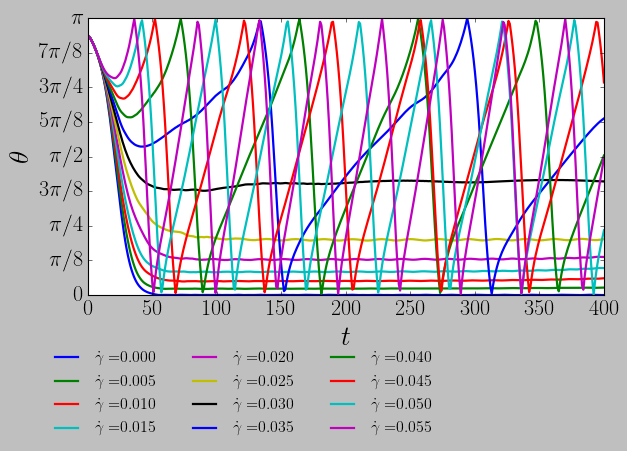

In [79]:
yticks = np.linspace(0, np.pi, 9)
yticks_str = ['$0$', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$', '$5\pi/8$','$3\pi/4$', '$7\pi/8$','$\pi$']
plt.xticks(fontsize=20)
plt.yticks(yticks, yticks_str, fontsize=20)
plt.ylim(0, np.pi)
for d, g in zip(radian_map['02'][l:k], gammadot_map['02'][l:k]):
    plt.plot(d, label='$\dot{\gamma}=$' + f'${g:0=0.3f}$')
plt.xlabel("$t$", fontsize=25)
plt.ylabel(r"$\theta$", fontsize=25)
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.15), loc='upper left')
plt.tight_layout()
plt.savefig('figs/degrees_02.png')

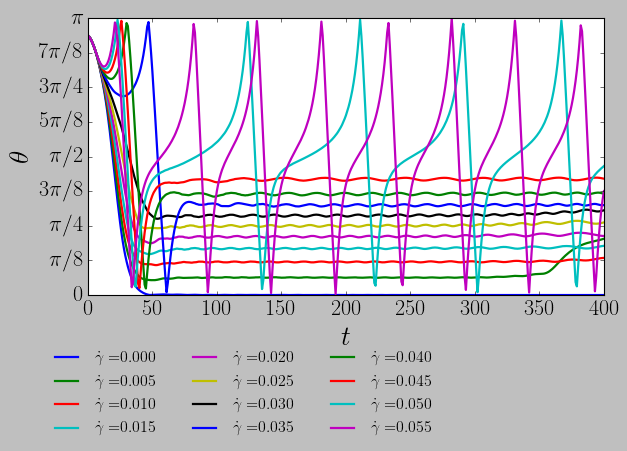

In [120]:
yticks = np.linspace(0, np.pi, 9)
yticks_str = ['$0$', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$', '$5\pi/8$','$3\pi/4$', '$7\pi/8$','$\pi$']
plt.xticks(fontsize=20)
plt.yticks(yticks, yticks_str, fontsize=20)
plt.ylim(0, np.pi)
for d, g in zip(radian_map['03'][l:k], gammadot_map['03'][l:k]):
    plt.plot(d, label='$\dot{\gamma}=$' + f'${g:0=0.3f}$')
plt.xlabel("$t$", fontsize=25)
plt.ylabel(r"$\theta$", fontsize=25)
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.15), loc='upper left')
plt.tight_layout()
plt.savefig('figs/degrees_03.png')

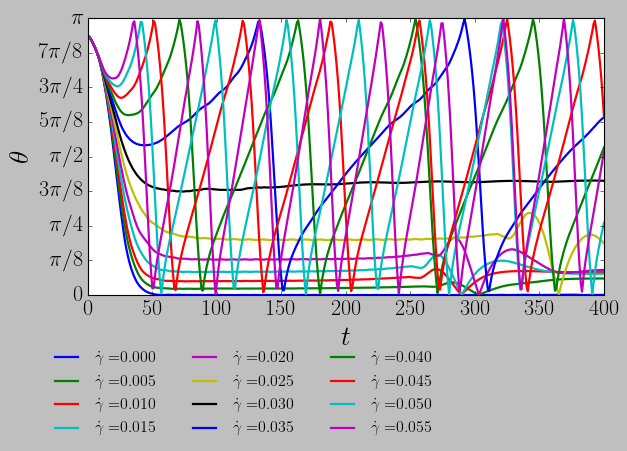

In [121]:
yticks = np.linspace(0, np.pi, 9)
yticks_str = ['$0$', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$', '$5\pi/8$','$3\pi/4$', '$7\pi/8$','$\pi$']
plt.xticks(fontsize=20)
plt.yticks(yticks, yticks_str, fontsize=20)
plt.ylim(0, np.pi)
for d, g in zip(radian_map['04'][l:k], gammadot_map['04'][l:k]):
    plt.plot(d, label='$\dot{\gamma}=$' + f'${g:0=0.3f}$')
plt.xlabel("$t$", fontsize=25)
plt.ylabel(r"$\theta$", fontsize=25)
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.15), loc='upper left')
plt.tight_layout()
plt.savefig('figs/degrees_04.png')

In [117]:
for i, g in enumerate(np.arange(0.0, 0.105, 0.005)):
    if (g * 1000) % 10 == 0:
        print(f'{g:0=0.3f}', f'{round(np.degrees(radian_map["00"][i][-1]), 0):0=3.0f}', f'{round(np.degrees(radian_map["01"][i][-1]), 0):0=3.0f}', f'{round(np.degrees(radian_map["02"][i][-1]), 0):0=3.0f}')

0.000 000 000 000
0.010 012 021 011
0.020 024 037 025
0.030 037 053 074
0.040 053 065 091
0.050 082 087 042
0.060 132 072 126
0.070 071 098 166
0.080 062 042 177
0.090 121 179 179
0.100 077 011 166
